# Introduction: Cell Segmentation for Student Group Work

In this project, we tackle the task of **cell instance segmentation** using a limited dataset of 2D microscopy images. This is part of a group assignment designed to apply the image analysis techniques learned throughout the course—including traditional methods like smoothing, thresholding, and morphological operations, as well as modern deep learning-based segmentation models.

---

## Problem Statement

You are provided with a **training set of 7 grayscale microscopy images** and their corresponding **ground truth masks**. The challenge is to build a robust segmentation pipeline that accurately detects and segments **cell outlines**. After development and training, the pipeline is evaluated on **3 test images** whose ground truth masks are hidden.

---

## Our Approach

To build and evaluate our segmentation pipeline, we follow these structured steps:

1. **Visualize the Images**
   We begin by loading and displaying the raw image data alongside their corresponding masks to understand the image structure and variability across the dataset.

2. **Explore the Dataset**
   Basic inspection of image shapes, channels, and characteristics helps define the input modality and preprocessing needs. We specifically use the cytoplasm channel for segmentation.

3. **Apply Pretrained Cellpose Model**
   We first test the performance of the **CellposeSAM** model—a state-of-the-art pretrained segmentation model—on the training images, and evaluate its results against the provided ground truth.

4. **Prepare the Dataset for Training**
   To fine-tune the model, we format the data into a training and validation split, saving images and masks in a structure compatible with Cellpose’s training pipeline.

5. **Retrain the Model on Labeled Data**
   We use Cellpose’s built-in training utilities to retrain a model from scratch using the 7 labeled training images, optimizing segmentation performance on our specific dataset.

6. **Evaluate and Report Final Results**
   We assess both the pretrained and custom-trained models on the training and validation sets using **Average Precision at IoU 0.5**. Finally, we apply the best-performing model to the 3 test images and save the predicted masks for submission.

This workflow demonstrates how limited data, combined with transfer learning and careful evaluation, can produce high-quality instance segmentation results. It also serves as a hands-on exercise in building real-world biomedical imaging pipelines from start to finish.

---

## Setup

Before diving into data exploration and model development, we begin by setting up the environment to ensure smooth execution throughout the project. This step is essential, especially when working in **Google Colab** or other cloud-based platforms, where external storage access and runtime configurations need to be handled explicitly.

### 1. Mounting Google Drive

Since our dataset is stored on Google Drive, we first **mount the drive** to access the image and mask files. This allows us to load, process, and save files directly from the Drive, enabling persistent storage across sessions.

In [1]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Installing Dependencies

We install required Python packages such as:

* `cellpose` for deep learning-based cell segmentation,
* `tifffile` for reading multi-dimensional `.tiff` images,
* `imagecodecs` (if needed) for efficient TIFF compression support.

> Note: In Colab, we must install these packages during runtime because the environment resets on each session.

In [2]:
# Install necessary packages

!pip install cellpose tifffile imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 3. Checking GPU Runtime

We check if a **GPU** is available in the current runtime. Using a GPU significantly speeds up model inference and training when using deep learning frameworks like **Cellpose**, especially on high-resolution images.

In [62]:
io.logger_setup()  # run this to get printing of progress

# Checking GPU
use_gpu = core.use_gpu()
if use_gpu:
    print("Using GPU for Cellpose")
else:
    raise ImportError("No GPU access, change your runtime as explained above.")

creating new log file
2025-07-19 04:48:47,330 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-19 04:48:47,331 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-19 04:48:47,333 [INFO] ** TORCH CUDA version installed and working. **
Using GPU for Cellpose


If GPU support is unavailable, training and inference will still work but may be considerably slower.

### 4. Folder Structure and Dataset Paths

We define and create the folder structure used throughout the project. This includes setting up root directories for:

* Raw images and ground truth masks
* Training and validation data splits
* Test images
* Model outputs and predicted masks

We also verify the presence of files and prepare lists of image filenames for loading in future steps.

In [27]:
ROOT_FOLDER = "/content/drive/MyDrive/bobiac_2025/"
DATA_FOLDER = str(ROOT_FOLDER) + "student_work_group_new/data"
TRAIN_DIR = str(ROOT_FOLDER) + "student_work_group_new/training"
VALIDATE_DIR = str(ROOT_FOLDER) + "student_work_group_new/validation"
TEST_DIR = str(ROOT_FOLDER) + "student_work_group_new/test"

```rust
student_group_work/
    ├── training/         ← for training images and masks
    ├── validation/       ← for validation images and masks
    └── data/             ← original raw files
```

*Optional: If the dataset isn’t already available, it can be downloaded and unzipped using the following:*

In [28]:
!wget -P {ROOT_FOLDER} https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/data/student_work_group_new.zip
!cd {ROOT_FOLDER} && unzip student_work_group_new.zip && rm -f student_work_group_new.zip && rm -r __MACOSX
!mkdir {TRAIN_DIR}
!mkdir {VALIDATE_DIR}

--2025-07-19 04:15:35--  https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/data/student_work_group_new.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892215 (871K) [application/zip]
Saving to: ‘/content/drive/MyDrive/bobiac_2025/student_work_group_new.zip’

student_work_group_ 100%[===================>] 871.30K  --.-KB/s    in 0.04s   

2025-07-19 04:15:35 (20.8 MB/s) - ‘/content/drive/MyDrive/bobiac_2025/student_work_group_new.zip’ saved [892215/892215]

Archive:  student_work_group_new.zip
   creating: student_work_group_new/
  inflating: student_work_group_new/.DS_Store  
  inflating: __MACOSX/student_work_group_new/._.DS_Store  
   creating: student_work_group_new/data/
  inflating: student_work_group_new/data/004_masks.tif  
  inflating

In [45]:
# Import libraries

import os
import random
import tifffile
import matplotlib.pyplot as plt

from cellpose import models, core, train, io, plot, metrics

### Summary

By the end of this setup section, we will have:

* Access to the dataset via Google Drive
* A GPU-ready runtime (if available)
* All dependencies installed
* A clean and reproducible folder structure ready for experimentation

---
## Data exploration and visualization
### Step 1: Read and Organize Images and Masks

Let’s begin by **scanning the dataset folder** and separating the files into two lists:

* Microscopy images (e.g., `00X_img.tiff`)
* Corresponding masks (e.g., `00X_masks.tif`)

### Why this matters:

The image files and masks have **slightly different extensions** (`.tiff` vs `.tif`), so we need to detect and split them correctly before loading. Proper organization will make further processing easier and less error-prone.

### Code: Scan Folder and Separate Files

In [32]:
# List all files in the folder
all_files = os.listdir(DATA_FOLDER)

# Separate image files and mask files based on naming patterns
image_files = sorted([f for f in all_files if "_img.tiff" in f])
mask_files  = sorted([f for f in all_files if "_masks.tif" in f])

# Check if we correctly separated them
print("Image files:", image_files)
print("Mask files:", mask_files)

Image files: ['000_img.tiff', '001_img.tiff', '002_img.tiff', '003_img.tiff', '004_img.tiff', '005_img.tiff', '006_img.tiff', '007_img.tiff']
Mask files: ['000_masks.tif', '001_masks.tif', '002_masks.tif', '003_masks.tif', '004_masks.tif', '005_masks.tif', '006_masks.tif', '007_masks.tif']


---

### Step 2: Read the Files into Arrays

Now that we have two sorted lists—one for images and one for masks, we can use <a href="https://www.w3schools.com/python/python_lists_comprehension.asp" target="_blank">**list comprehensions**</a> to read them using `tifffile`. Each image is multi-channel (2, H, W), so we’ll specifically extract **channel 0 and channel 1** separately later if needed.

In [36]:
# Read image stacks into memory
images = [tifffile.imread(f"{DATA_FOLDER}/{fname}") for fname in image_files]  # shape: (2, H, W)
masks = [tifffile.imread(f"{DATA_FOLDER}/{fname}") for fname in mask_files]    # shape: (H, W)

# Check shapes
print(f"\nLoaded {len(images)} images and {len(masks)} masks.")
print("Example image shape:", images[0].shape)
print("Example mask shape:", masks[0].shape)


Loaded 8 images and 8 masks.
Example image shape: (2, 383, 512)
Example mask shape: (383, 512)


---

### Step 3: Visualize with List Comprehension

Let’s now visualize the two channels of each image alongside the corresponding mask using a compact loop.

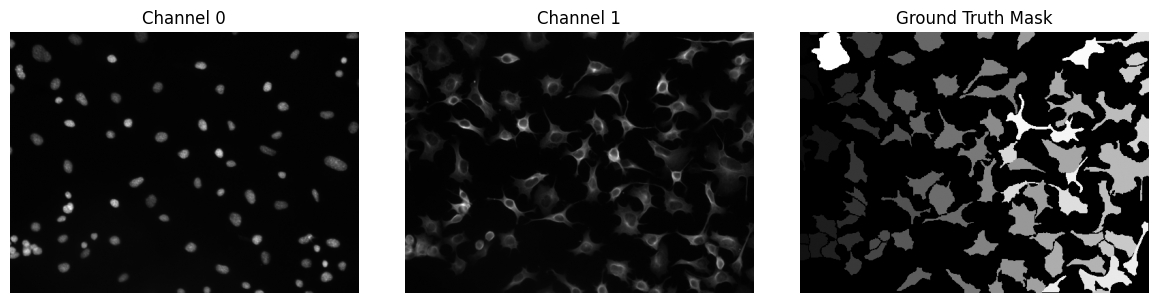

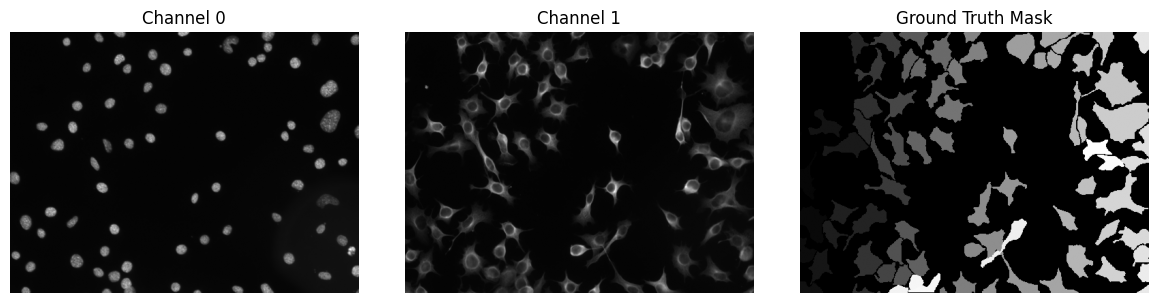

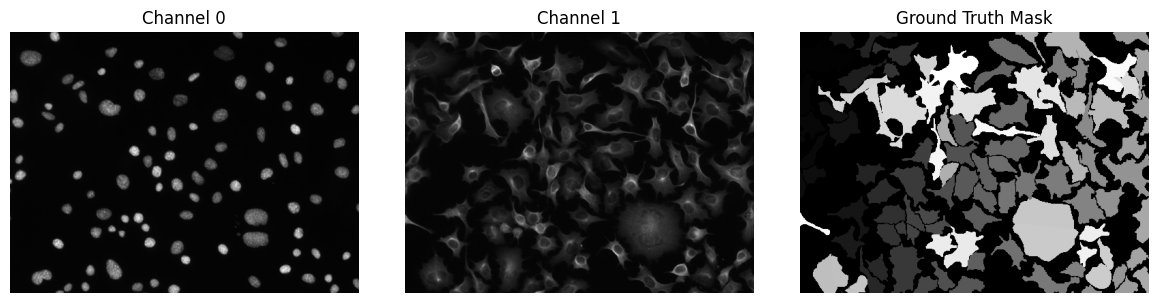

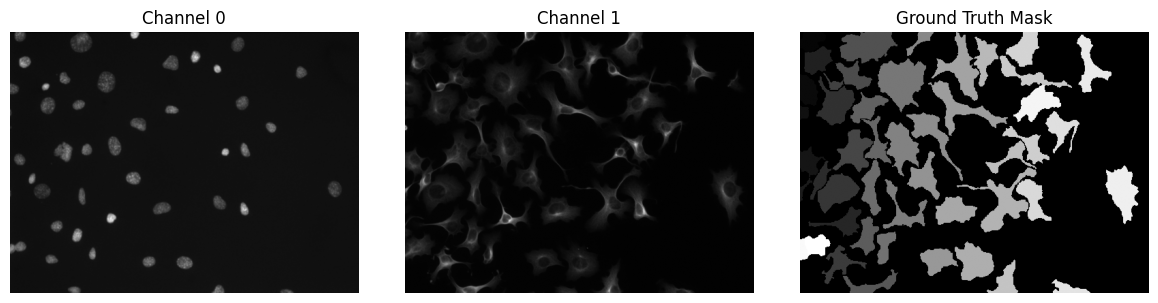

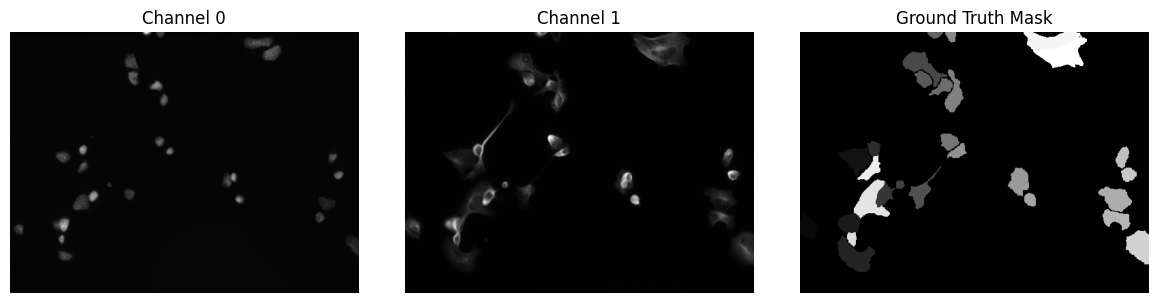

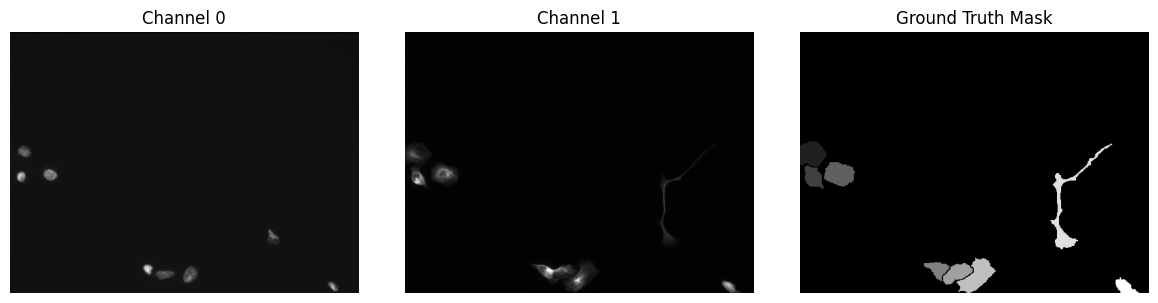

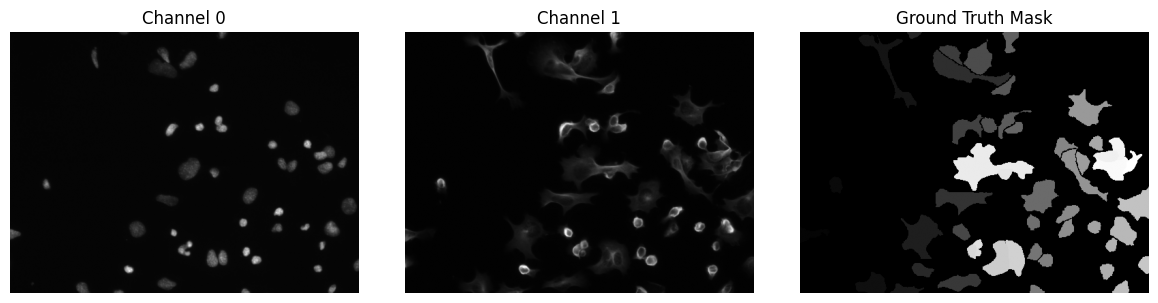

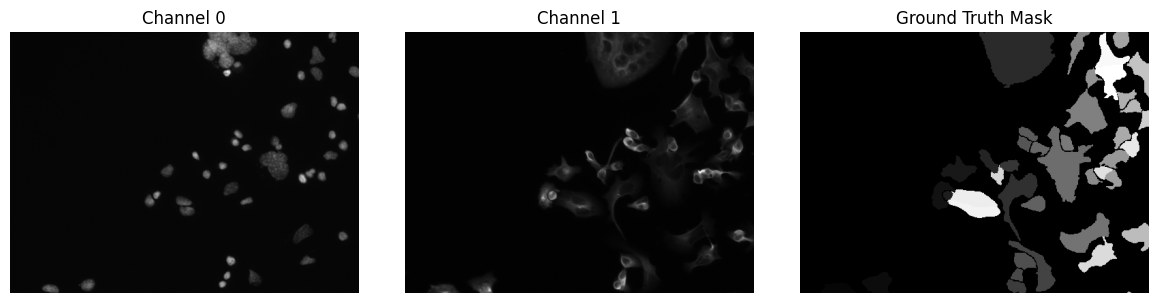

In [38]:
# Loop through and visualize each sample
for img, mask in zip(images, masks):
    plt.figure(figsize=(12, 3))

    # Channel 0 (e.g., nucleus)
    plt.subplot(1, 3, 1)
    plt.imshow(img[0], cmap='gray')
    plt.title("Channel 0")
    plt.axis('off')

    # Channel 1 (e.g., cytoplasm)
    plt.subplot(1, 3, 2)
    plt.imshow(img[1], cmap='gray')
    plt.title("Channel 1")
    plt.axis('off')

    # Corresponding ground truth mask
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

---

### Summary

* We successfully read **multi-channel `.tiff` images** and **mask `.tif` files**.
* Confirmed that each image has two channels, and masks align in shape.
* Created a clean visualization of image + mask triplets for inspection.

This ensures that all inputs are loaded correctly before we proceed to model inference using Cellpose.


---

## CellposeSAM to segment cytoplasm

* We'll extract the **cytoplasm channel** (channel 1) from each multi-channel image.
* Feed these single-channel images into **CellposeSAM** to generate predicted masks.
* Then we’ll **randomly visualize** one image with:

  * Cytoplasm channel,
  * Ground truth mask,
  * Predicted mask (from CellposeSAM).

---

## Segment Cells using CellposeSAM (Cytoplasm Channel Only)

Now that we’ve loaded and inspected the multi-channel images, it's time to:

* Select **only the cytoplasm channel** from each image,
* Feed these images into the **pre-trained CellposeSAM model** for segmentation,
* Compare predicted masks with the provided ground truth.

### Why the cytoplasm channel?

Cellpose performs instance segmentation based on cellular structures. While both nucleus (channel 0) and cytoplasm (channel 1) are informative, the **cytoplasm channel is more relevant** for full cell boundary segmentation in most microscopy datasets.

In [39]:
### Extract Cytoplasm Channel

# Extract cytoplasm (channel 1) from each image
cytoplasm_images = [img[1] for img in images]  # Each img has shape (2, H, W)

# Check that shapes are preserved and 2D
print(f"Extracted {len(cytoplasm_images)} cytoplasm images.")
print("Shape of one image:", cytoplasm_images[0].shape)

Extracted 8 cytoplasm images.
Shape of one image: (383, 512)


---

### Load CellposeSAM and Run Prediction

We now initialize the **CellposeSAM** model (pretrained variant of Cellpose) and run it on our list of cytoplasm images.

In [41]:
# Initialize model with GPU support (if available)
use_gpu = core.use_gpu()
print(f"Using GPU: {use_gpu}")

# Load the CellposeSAM model
model = models.CellposeModel(gpu=use_gpu, model_type='cpsam')

# Run the model to predict segmentation masks
predicted_masks, _, _ = model.eval(cytoplasm_images)

Using GPU: True


100%|██████████| 1.15G/1.15G [00:04<00:00, 251MB/s]


> The `eval()` method returns:
>
> * `predicted_masks`: list of predicted instance masks,
> * `flows` and `styles`: internal model outputs (not used here).

---

### Visualize a Random Example

Let’s now pick one random image from the dataset and visualize:

* The **cytoplasm input**,
* The **ground truth mask**, and
* The **CellposeSAM predicted mask**.

This helps us qualitatively assess the model's performance.

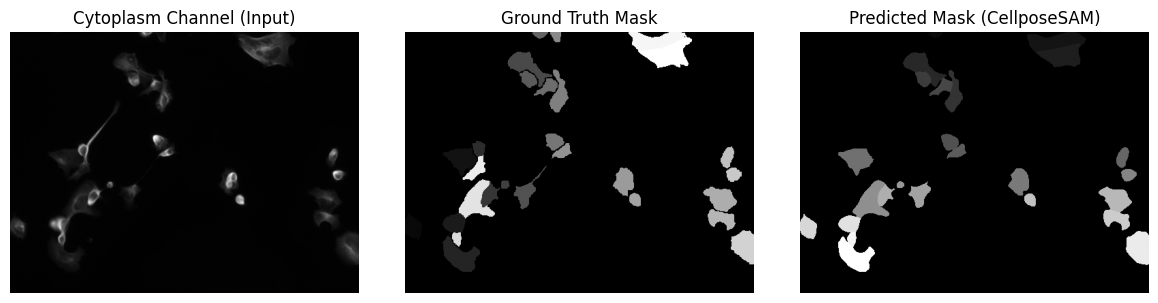

In [44]:
# Choose a random index
idx = random.randint(0, len(cytoplasm_images) - 1)

# Extract relevant elements
cyto_img = cytoplasm_images[idx]
true_mask = masks[idx]
pred_mask = predicted_masks[idx]

# Visualize
plt.figure(figsize=(12, 3))

# Cytoplasm channel image
plt.subplot(1, 3, 1)
plt.imshow(cyto_img, cmap='gray')
plt.title("Cytoplasm Channel (Input)")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask (CellposeSAM)")
plt.axis('off')

plt.tight_layout()
plt.show()

---

### Evaluate CellposeSAM with Average Precision

Now that we’ve obtained predicted masks from the **CellposeSAM** model, it's important to go beyond visual inspection and measure **how accurate the segmentation is**.

We'll compute the **Average Precision (AP)** between the predicted and ground truth masks using Cellpose’s built-in `metrics.average_precision()` function.



#### What is Average Precision (AP) in this context?

* It evaluates **instance segmentation quality** by checking if predicted cell regions match true ones.
* Uses **IoU threshold (typically 0.5)** to determine if a prediction counts as a correct match.
* The average is taken over all instances to get a single AP score.
* **Mean AP (mAP)** is computed if multiple thresholds are used (we’ll use just 0.5 here).

In [46]:
# Compute average precision at IoU threshold = 0.5
ap_result = metrics.average_precision(masks, predicted_masks)  # returns a tuple
ap = ap_result[0]  # [n_images x n_thresholds] array

# Calculate mean AP across all images at IoU=0.5 (index 0)
mean_ap = ap[:, 0].mean()
print(f"\n>>> Average Precision (AP) at IoU 0.5 across {len(masks)} images: {mean_ap:.3f}")


>>> Average Precision (AP) at IoU 0.5 across 8 images: 0.899


---

### Summary

* We **extracted the cytoplasm channel (channel 1)** from all images to focus on full-cell segmentation.
* Used **CellposeSAM**, a powerful pretrained segmentation model, to predict instance masks.
* Randomly visualized one image to **qualitatively compare model predictions** against ground truth.
* Measured *mAP* to check how well the CellposeSAM segmented the images.

This gives us a first look at how well a pretrained model generalizes to our dataset. Next, we’ll make this dataset **training-ready** and begin the process of **fine-tuning Cellpose** on our specific images.

---

## Prepare Dataset for Retraining CellposeSAM

To improve segmentation performance on our dataset, we now fine-tune the **Cellpose** model using the provided labeled images. This involves:

1. Extracting only the **cytoplasm channel (channel = 1)** from each image,
2. Saving them in the format required by Cellpose:

   * `.tif` files for input images
   * `_seg.tif` files for segmentation masks
3. Splitting into **training (6 images)** and **validation (2 images)** sets.

In [49]:
# Save images and masks in appropriate folders
for i in range(len(images)):
    if i < 6:  # First 6 images for training
        tifffile.imwrite(f"{TRAIN_DIR}/00{i}.tif", images[i])
        tifffile.imwrite(f"{TRAIN_DIR}/00{i}_seg.tif", masks[i])
    else:      # Remaining 2 images for validation
        tifffile.imwrite(f"{VALIDATE_DIR}/00{i}.tif", images[i])
        tifffile.imwrite(f"{VALIDATE_DIR}/00{i}_seg.tif", masks[i])

> ⚠️ Note: Cellpose accepts either `_seg.tif` or `_seg.npy` for masks. Here, we use `.tif` for consistency.

In [50]:
# Load Data Using Cellpose I/O Utility

from cellpose import io

# Define mask suffix used for ground truth labels
masks_ext = "_seg"

# Load training and validation sets
train_data, train_labels, _, validation_data, validation_label, _ = io.load_train_test_data(
    TRAIN_DIR,
    VALIDATE_DIR,
    mask_filter=masks_ext
)

print(f"Loaded {len(train_data)} training samples and {len(validation_data)} validation samples.")

Loaded 6 training samples and 2 validation samples.


---

## Train a Custom Model

Now that the dataset is ready, we retrain a segmentation model using the Cellpose framework.

We define training parameters like learning rate and weight decay and let the Cellpose `train_seg()` function handle the rest.

In [59]:
# Training Parameters

from cellpose import train

# Define model name
model_name = f"{ROOT_FOLDER}/new_model"

# Training hyperparameters
n_epochs = 100
learning_rate = 1e-5
weight_decay = 0.1

# Train the model using Cellpose's built-in function
# (We skip test data here to speed up training)
new_model_path, train_losses, test_losses = train.train_seg(
    net=model.net,
    train_data=train_data,
    train_labels=train_labels,
    test_data=validation_data,
    test_labels=validation_label,
    model_name=model_name,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay
)

100%|██████████| 2/2 [00:00<00:00, 790.26it/s]


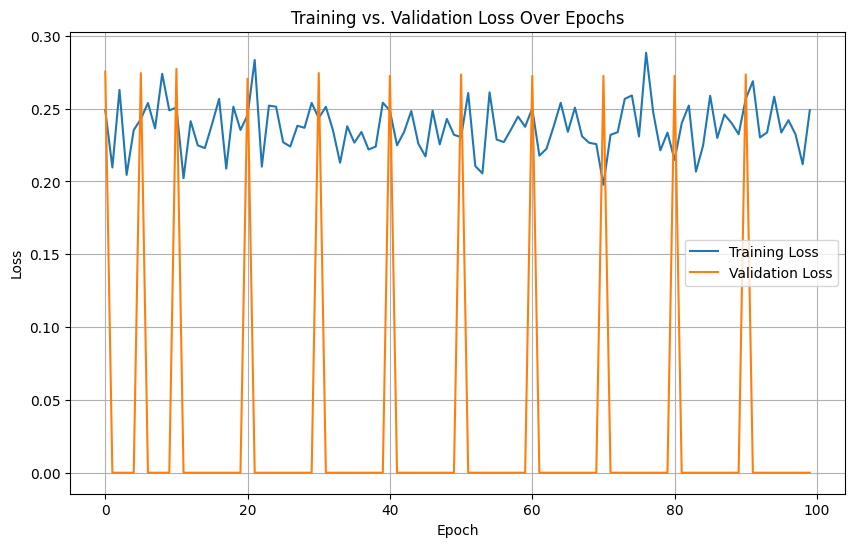

In [60]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Measure accuracy

In [61]:
# Load the newly trained CellposeSAM model
model = models.CellposeModel(gpu=use_gpu, pretrained_model=new_model_path)

# Run the model to predict segmentation masks
predicted_masks, _, _ = model.eval(cytoplasm_images)

# Compute average precision at IoU threshold = 0.5
ap_result = metrics.average_precision(masks, predicted_masks)  # returns a tuple
ap = ap_result[0]  # [n_images x n_thresholds] array

# Calculate mean AP across all images at IoU=0.5 (index 0)
mean_ap = ap[:, 0].mean()
print(f"\n>>> Average Precision (AP) at IoU 0.5 across {len(masks)} images: {mean_ap:.3f}")


>>> Average Precision (AP) at IoU 0.5 across 8 images: 0.909


### Summary

| Step              | What We Did                                                   |
| ----------------- | ------------------------------------------------------------- |
| Extracted Channel | Used cytoplasm channel (1) from all multi-channel TIFF images |
| Dataset Split     | Saved 6 images for training, 2 for validation                 |
| File Format       | `.tif` for input and `_seg.tif` for masks                     |
| Training          | Trained Cellpose from scratch using custom parameters         |

You now have a **custom-trained segmentation model** fine-tuned for your dataset. Next, we’ll evaluate its performance and compare it to the pretrained model.